In [9]:
% pylab inline 
import os
import pandas as pd
import librosa
import librosa.display
import glob

Populating the interactive namespace from numpy and matplotlib


In [3]:
data, sampling_rate = librosa.load('data/Casio-MT-45-16-Beat.wav')

In [7]:
plt.figure(figsize = (12,4))

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

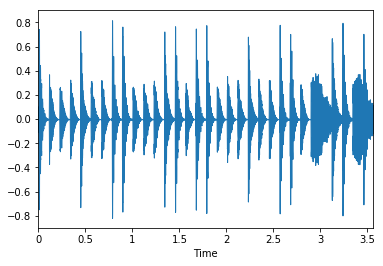

In [10]:
librosa.display.waveplot(data, sr=sampling_rate)

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import librosa

import librosa.display


In [2]:
y, sr = librosa.load('The Beatles - Hey Jude.mp3', duration=120)


# And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))

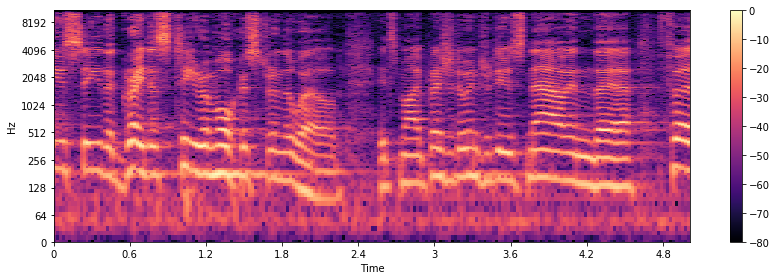

In [3]:
idx = slice(*librosa.time_to_frames([30, 35], sr=sr))
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.tight_layout()

In [4]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

In [5]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

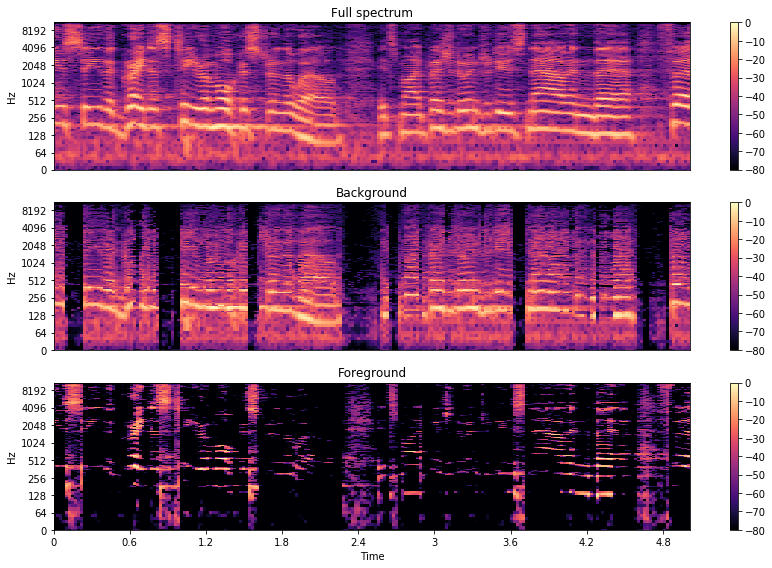

In [6]:
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

In [17]:
from tqdm import tqdm

def griffinlim(spectrogram, n_iter = 100, window = 'hann', n_fft = 2048, hop_length = -1, verbose = False):
    
    if hop_length == -1:
        hop_length = n_fft // 4

    angles = np.exp(2j * np.pi * np.random.rand(*spectrogram.shape))

    t = tqdm(range(n_iter), ncols=100, mininterval=2.0, disable=not verbose)
    
    for i in t:
        
        print ('Iter:' , i , ', Spectrogram Shape:', spectrogram.shape)
        print ('Iter:' , i , ', Angles Shape:', angles.shape)

        full = np.abs(spectrogram).astype(np.complex) * angles
        inverse = librosa.istft(full, hop_length = hop_length, window = window)
        rebuilt = librosa.stft(inverse, n_fft = n_fft, hop_length = hop_length, window = window)
        angles = np.exp(1j * np.angle(rebuilt))

        if verbose:
            diff = np.abs(spectrogram) - np.abs(rebuilt)
            t.set_postfix(loss=np.linalg.norm(diff, 'fro'))

    full = np.abs(spectrogram).astype(np.complex) * angles
    inverse = librosa.istft(full, hop_length = hop_length, window = window)

    return inverse

In [18]:
back = griffinlim(librosa.amplitude_to_db(S_foreground))

Iter: 0 , Spectrogram Shape: (1025, 5168)
Iter: 0 , Angles Shape: (1025, 5168)
Iter: 1 , Spectrogram Shape: (1025, 5168)
Iter: 1 , Angles Shape: (1025, 5168)
Iter: 2 , Spectrogram Shape: (1025, 5168)
Iter: 2 , Angles Shape: (1025, 5168)
Iter: 3 , Spectrogram Shape: (1025, 5168)
Iter: 3 , Angles Shape: (1025, 5168)
Iter: 4 , Spectrogram Shape: (1025, 5168)
Iter: 4 , Angles Shape: (1025, 5168)
Iter: 5 , Spectrogram Shape: (1025, 5168)
Iter: 5 , Angles Shape: (1025, 5168)
Iter: 6 , Spectrogram Shape: (1025, 5168)
Iter: 6 , Angles Shape: (1025, 5168)
Iter: 7 , Spectrogram Shape: (1025, 5168)
Iter: 7 , Angles Shape: (1025, 5168)
Iter: 8 , Spectrogram Shape: (1025, 5168)
Iter: 8 , Angles Shape: (1025, 5168)
Iter: 9 , Spectrogram Shape: (1025, 5168)
Iter: 9 , Angles Shape: (1025, 5168)
Iter: 10 , Spectrogram Shape: (1025, 5168)
Iter: 10 , Angles Shape: (1025, 5168)
Iter: 11 , Spectrogram Shape: (1025, 5168)
Iter: 11 , Angles Shape: (1025, 5168)
Iter: 12 , Spectrogram Shape: (1025, 5168)
Iter:

In [ ]:
"""https://librosa.github.io/librosa/generated/librosa.decompose.decompose.html

https://gist.github.com/mailletf/3484932dd29d62b36092
https://github.com/librosa/librosa/issues/434
=========================""""